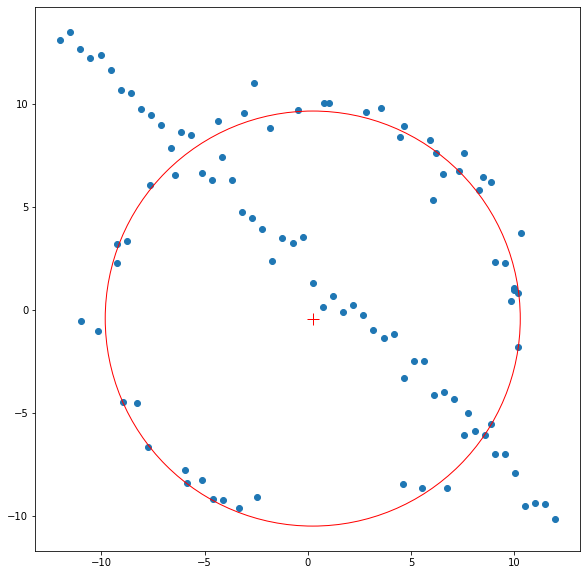

In [56]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt 
from math import sqrt

def noisy_data():
    N = 100
    half_n = N // 2
    r = 10
    s = r/16
    t = np.random.uniform(0 , 2*np.pi , half_n )
    n = s*np.random.randn(half_n)
    x , y = (r+n)*np.cos(t),(r + n)*np.sin(t)
    X_circ = np.hstack((x.reshape(half_n , 1 ) , y.reshape( half_n , 1 ) ) )
    m, b = -1, 2
    x = np.linspace(-12, 12 , half_n )
    y = m*x + b + s*np.random.randn( half_n )
    X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
    X = np.vstack(( X_circ , X_line ) )

    

    return X


def define_circle(p1, p2, p3):
    """
    Returns the center and radius of the circle passing the given 3 points.
    In case the 3 points form a line, returns (None, infinity).
    """
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return (None, np.inf)

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)


def ransac(data_set, threshold_dist, threshold_inliner_count, max_iteraions):
    shortlisted = []
    while max_iteraions:
        size_of_data = len(data_set)
        init_indices = np.random.randint(size_of_data, size = (3))
        init_cordinates = [data_set[i] for i in init_indices]

        #finding the circle passing through the init_cordinates
        #centre, radius = findcircle(init_cordinates[0][0],init_cordinates[0][1],init_cordinates[1][0],init_cordinates[1][1],init_cordinates[2][0],init_cordinates[2][1])
        centre, radius = define_circle(init_cordinates[0], init_cordinates[1], init_cordinates[2])
        if centre is not None:
                
            count = 0
            new_inliers = []
            for i in data_set:
                dist = sqrt((i[0] - centre[0])**2 + (i[1] - centre[1])**2)
                if dist > (radius - threshold_dist) and dist < (radius + threshold_dist):
                    count += 1
                    new_inliers.append(i)
            inliers = np.array(new_inliers)
            if count > threshold_inliner_count:
                #calculate mean absolute error
                mse = np.array([sqrt(i[0] + i[1]) for i in (inliers - centre)**2]) - radius
                mse = sum([abs(i) for i in mse]) / len(inliers)
                
                shortlisted.append((centre,radius,len(inliers),mse))
        
        max_iteraions -= 1

    max_inliers = threshold_inliner_count
    best_option = 0
    min_error = 1000
    for i in shortlisted:
        if i[2] > max_inliers:
            max_inliers = i[2]
            best_option = i
        elif i[2] == max_inliers:
            if i[3] < min_error:
                min_error = i[3]
                best_option = i

    return best_option




X1 = noisy_data()
X_data = []
Y_data = []
for vals in X1:
    X_data.append(vals[0])
    Y_data.append(vals[1])

fig, ax = plt.subplots(figsize= (10,10))
ax.scatter(X_data, Y_data)

# show result
result = ransac(X1, 1, 15, 100) 
(a,b),r = result[0],result[1]
circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False)
plt.gca().add_patch(circle)
plt.plot(a, b, 'r', marker='+', markersize=12)

plt.axis('scaled')
plt.show()

In [27]:
a = np.array([  [1,2],
                [3,4],
                [5,6]   ])
b = (1,1)


print((a-b)**2)
print((a-b)**2 - 1)

[[ 0  1]
 [ 4  9]
 [16 25]]
[[-1  0]
 [ 3  8]
 [15 24]]


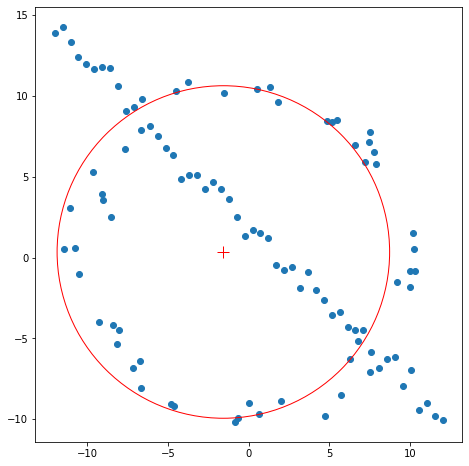

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy . optimize import minimize


def generate_data():
	X_data, Y_data = [],[]
	N = 100
	half_n = N // 2
	r = 10
	s = r/16
	t = np.random.uniform(0 , 2*np.pi , half_n )
	n = s*np.random.randn(half_n)
	x , y = (r+n)*np.cos(t),(r + n)*np.sin(t)
	X_circ = np.hstack((x.reshape(half_n , 1 ) , y.reshape( half_n , 1 ) ) )
	m, b = -1, 2
	x = np.linspace(-12, 12 , half_n )
	y = m*x + b + s*np.random.randn( half_n )
	X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
	X = np.vstack(( X_circ , X_line ) )

	for vals in X:
		X_data.append(vals[0])
		Y_data.append(vals[1])

	return X_data, Y_data


class RANSAC:
	def __init__(self, x_data, y_data, n):
		self.x_data = x_data
		self.y_data = y_data
		self.n = n
		self.d_min = 99999
		self.best_model = None

	def random_sampling(self):
		sample = []
		save_ran = []
		count = 0

		# get three points from data
		while True:
			ran = np.random.randint(len(self.x_data))

			if ran not in save_ran:
				sample.append((self.x_data[ran], self.y_data[ran]))
				save_ran.append(ran)
				count += 1

				if count == 3:
					break

		return sample

	def make_model(self, sample):
		# calculate A, B, C value from three points by using matrix
	
		pt1 = sample[0]
		pt2 = sample[1]
		pt3 = sample[2]

		A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
		B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
		inv_A = inv(A)

		c_x, c_y = np.dot(inv_A, B) / 2
		c_x, c_y = c_x[0], c_y[0]
		r = np.sqrt((c_x - pt1[0])**2 + (c_y - pt1[1])**2)

		return c_x, c_y, r

	def eval_model(self, model):
		d = 0
		c_x, c_y, r = model

		for i in range(len(self.x_data)):
			dis = np.sqrt((self.x_data[i]-c_x)**2 + (self.y_data[i]-c_y)**2)

			if dis >= r:
				d += dis - r
			else:
				d += r - dis
		
		return d

	def execute_ransac(self):
		# find best model
		for i in range(self.n):
			model = self.make_model(self.random_sampling())
			d_temp = self.eval_model(model)
			
			if self.d_min > d_temp:
				self.best_model = model
				self.d_min = d_temp


if __name__ == '__main__':
	# make data
	x_data, y_data = generate_data()

	# show data by scatter type
	plt.figure(figsize=(8, 8))
	plt.scatter(x_data, y_data, marker='o', label='data')

	# make ransac class
	# n: how many times try sampling
	ransac = RANSAC(x_data, y_data, 50)
	
	# execute ransac algorithm
	ransac.execute_ransac()
	
	# get best model from ransac
	a, b, r = ransac.best_model[0], ransac.best_model[1], ransac.best_model[2]

	# show result
	circle = plt.Circle((a, b), radius=r, color='r', fc='y', fill=False)
	plt.gca().add_patch(circle)
	plt.plot(a, b, 'r', marker='+', markersize=12)

	plt.axis('scaled')

	# plt.tight_layout()
	plt.show()

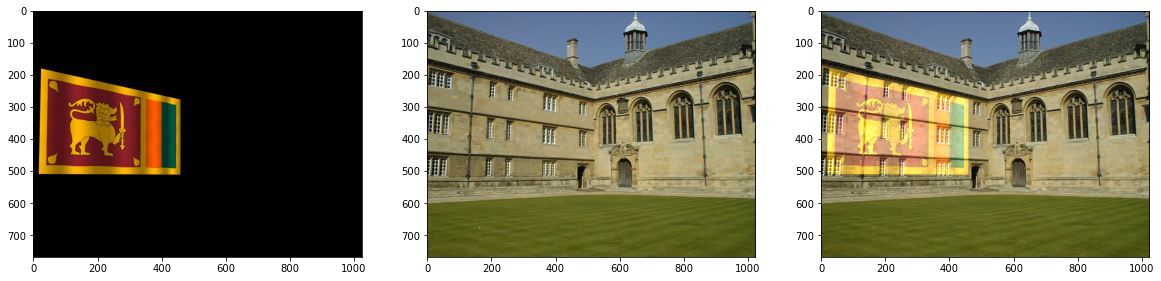

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (0, 0, 255), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('flagsri.jpg')
size = im_src.shape
   
    # Create a vector of source points.
pts_src = np.array(
                       [
                        [0,0],
                        [size[1] - 1, 0],
                        [size[1] - 1, size[0] -1],
                        [0, size[0] - 1 ]
                        ],dtype=float
                       )


im_dst = cv2.imread('001.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break



h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,.6,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
plt.show()

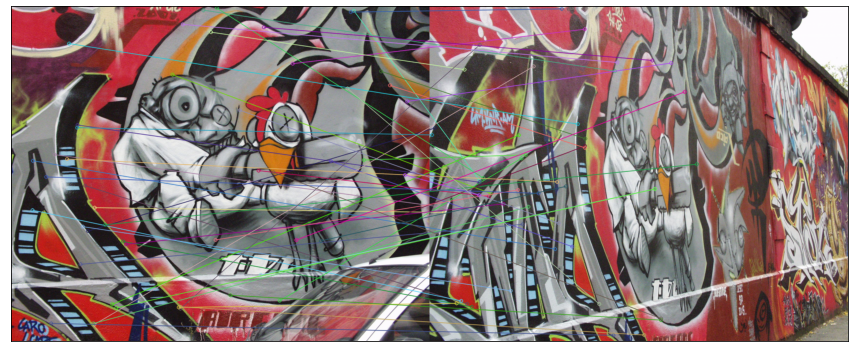

In [5]:
# Question 03
import cv2 
import matplotlib.pyplot as plt

img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm') 

#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#Making cross_check true is a good alternative to ratio test
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()

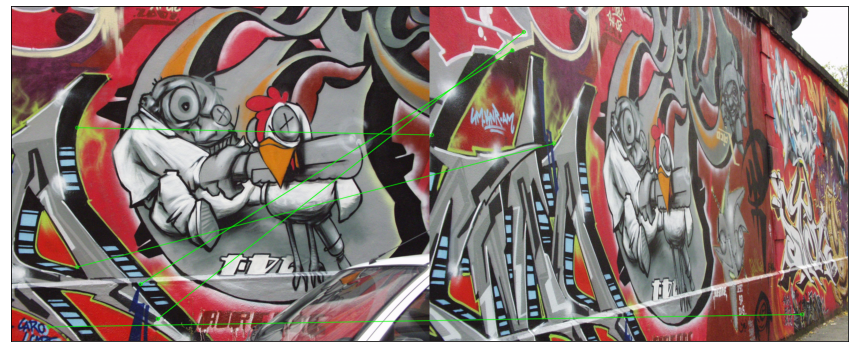

In [11]:
# Question 03
import cv2 
import matplotlib.pyplot as plt

img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm') 



sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#Making cross_check true is a good alternative to ratio test
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

sourcePoints = np.float32([keypoints_1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dstPoints = np.float32([keypoints_2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

#obtaining homography matrix
M, mask = cv2.findHomography(sourcePoints, dstPoints, method = cv2.RANSAC, ransacReprojThreshold = 5.0)
matchesMask = mask.ravel().tolist()

#apply perspective transformation to the source image corners
h = img1.shape[0]
w = img1.shape[1]
corners = np.float32([[0,0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
transformedCorners = cv2.perspectiveTransform(corners, M)

#drawing a polygon on the second image joining transformed corners
img2 = cv2.polylines(img2, [np.int32(transformedCorners)], True, (255, 255, 255), 2, cv2.LINE_AA)

drawParameters = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches, None, **drawParameters)


plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([])
plt.show()